# Fitting Stokseth and Gaussian approximations to our measured MTF

In [1]:
from srayan_dof import *
from scipy.optimize import curve_fit
import pandas as pd
import diplib as dip

DIPlib -- a quantitative image analysis library
Version 3.3.0 (May 21 2022)
For more information see https://diplib.org


In [2]:
BASE_PATH = '../../data_store/2022-10-31 dof contd/aperture/'
f22 = BASE_PATH + '2022-10-31-f22 depth sweep wide range stack/MMStack_Pos0.ome.tif'
E = np.arange(25, -1, -1)

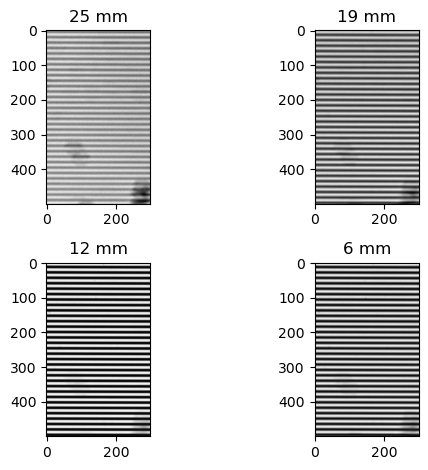

In [3]:
im = load_disp_img(f22, E, disp=True)

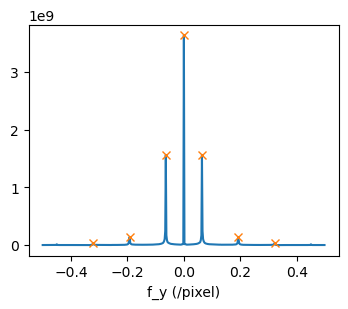

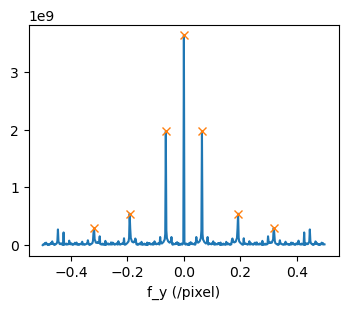

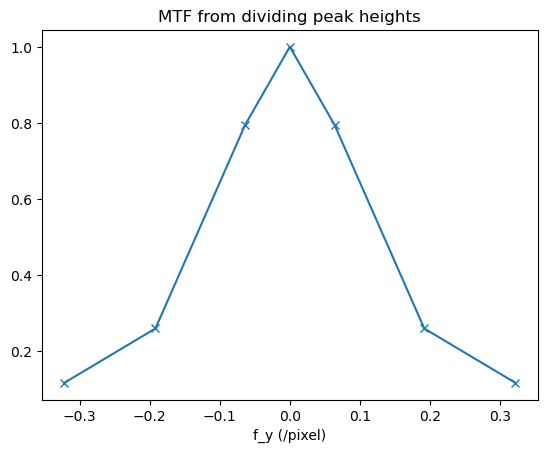

In [4]:
get_mtf_peakdivide(im, 11, E, thresh=0.275e9)

In [5]:
# adapted from https://www.johndcook.com/blog/2012/02/02/how-to-compute-jincx/
from scipy.special import j1

def jinc(x):
    # if x == 0.0:
    #     return 1
    return 2 * (j1(x) / x)

jinc = np.vectorize(jinc)

In [6]:
def castleman(s, w, k=(2*np.pi)/(550e-9)):
    """
    Stokseth approximation to the OTF, as described
    in Digital Image Processing (Castleman, 1995)

    s = reduced spatial frequency (just treating as spatial freq. for now)
    k = 2 pi / lambda
    w = max path length error (measure of defocus)

    """

    poly = (1 - 0.69*s + 0.0076*(s**2) + 0.043*(s**3))
    j = jinc(4 * k * w * (1 - np.abs(s)/2) * (s/2))
    return poly * j

/tmp/ipykernel_141310/1156599093.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (j1(x) / x)


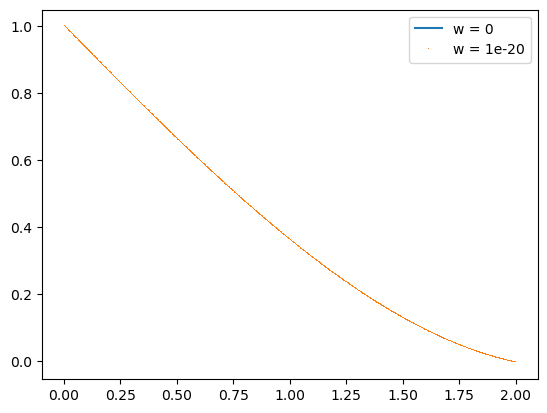

In [7]:
s = np.linspace(0, 2, 1000)
plt.plot(s, castleman(s, 0), label='w = 0')
plt.plot(s, castleman(s, 5e-15), ',', label='w = 1e-20')
plt.legend()
plt.show()

/tmp/ipykernel_141310/1156599093.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (j1(x) / x)


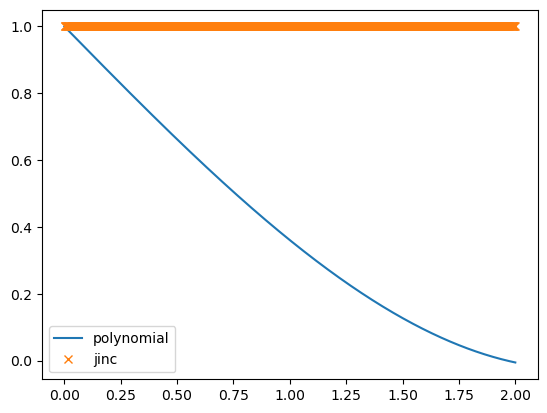

In [8]:
plt.plot(s, (1 - 0.69*s + 0.0076*(s**2) + 0.043*(s**3)), label='polynomial')
plt.plot(s, jinc(4 * (2*np.pi)/(550e-9) * 5e-15 * (1 - np.abs(s)/2) * (s/2)), 'x', label='jinc')
plt.legend()
plt.show()

/tmp/ipykernel_141310/1156599093.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (j1(x) / x)


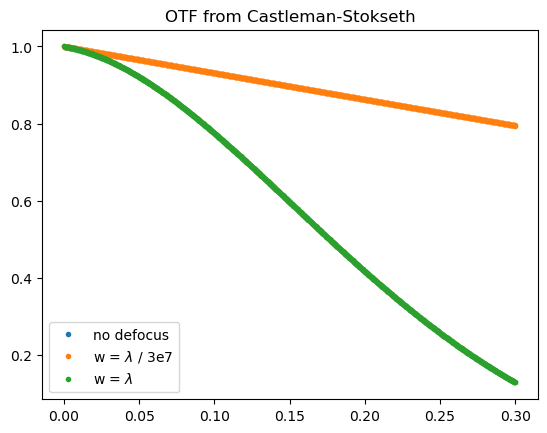

In [9]:
s = np.linspace(0, 0.3, 1000)
plt.plot(s, castleman(s, 0), '.', label='no defocus')
plt.plot(s, castleman(s, 550e-9/3e7), '.', label=r'w = $\lambda$ / 3e7')
plt.plot(s, castleman(s, 550e-9), '.', label=r'w = $\lambda$')
plt.legend()
plt.title('OTF from Castleman-Stokseth')
plt.show()

In [10]:
def mtf_fit_castleman(im, frame, positions, thresh=0.25e9):
    # WARNING: hardcoded number of peaks to select here
    # pls fix soon
    # code will not work for other images

    idealsquare, idealgrating = fit_square_to_lineprof(
        im, 13, positions
    )  # fit in-focus

    ft_im, freqs_im = fourier(im[frame])
    ft_ideal, freqs_ideal = fourier(idealgrating)

    plt.figure(figsize=(4, 3))
    peaks_im, props_im = fft_find_peaks(im[frame], disp=True)
    plt.figure(figsize=(4, 3))
    peaks_ideal, props_ideal = fft_find_peaks(idealgrating, thresh=thresh, disp=True)

    d = {
        "image_indices": peaks_im,
        "image_heights": props_im["peak_heights"],
        "ideal_indices": peaks_ideal,
        "ideal_heights": props_ideal["peak_heights"],
    }

    df = pd.DataFrame(data=d)

    image_indices = df["image_indices"].tolist()
    df["ideal_heights_at_image_indices"] = np.abs(ft_ideal)[:, ft_im.shape[1] // 2][
        image_indices
    ]
    ideal_indices = df["ideal_indices"].tolist()
    df["image_heights_at_ideal_indices"] = np.abs(ft_im)[:, ft_im.shape[1] // 2][
        ideal_indices
    ]

    plt.plot(
        np.fft.fftshift(freqs_im[0])[image_indices][3:],
        (df["image_heights"] / df["ideal_heights"])[3:],
        "-x",
    )

    popt, pcov = sp.optimize.curve_fit(castleman, np.fft.fftshift(freqs_im[0])[image_indices][3:], (df["image_heights"]/df["ideal_heights"])[3:], p0=[1.1*550e-9])

    freqs_to_plot = np.linspace(0, max(np.fft.fftshift(freqs_im[0])[image_indices][3:]), 1000)
    plt.plot(freqs_to_plot, castleman(freqs_to_plot, *popt), ',')
    print(f'Fitted parameter: w = {popt}')

    plt.xlabel("f_y (/pixel)")
    plt.title("MTF from dividing peak heights")

    plt.show()

    return np.fft.fftshift(freqs_im[0])[image_indices][3:], (df["image_heights"]/df["ideal_heights"])[3:], freqs_to_plot, castleman(freqs_to_plot, *popt)

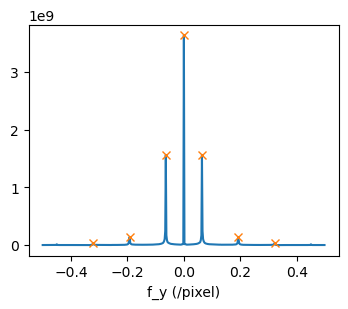

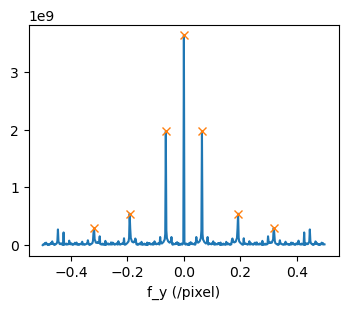

Fitted parameter: w = [6.05e-07]


/tmp/ipykernel_141310/1156599093.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (j1(x) / x)
/home/srayan/miniconda3/envs/opt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


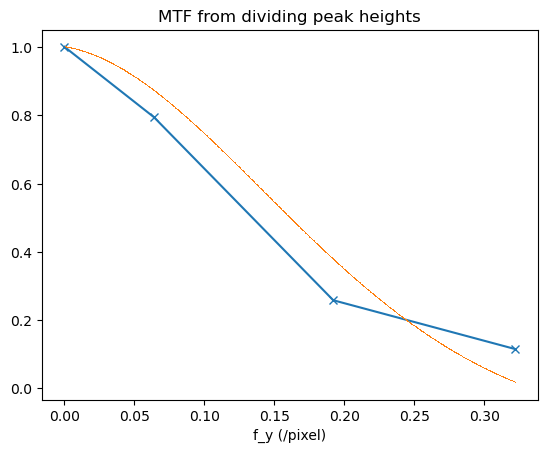

In [11]:
true_mtf_x, true_mtf_y, fitted_mtf_x, fitted_mtf_y = mtf_fit_castleman(im, 11, E, thresh=0.275e9)

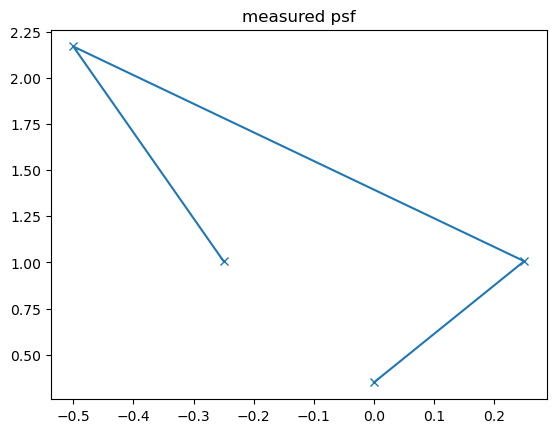

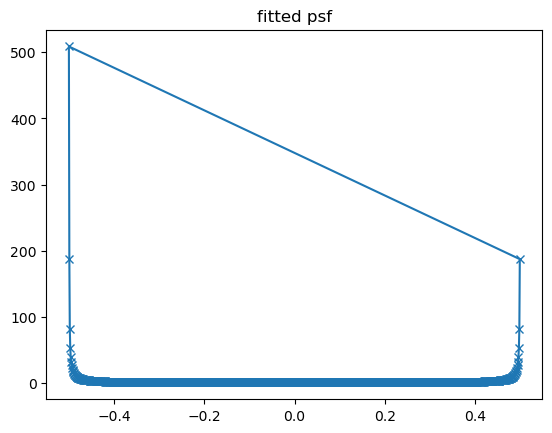

In [12]:
true_psf = np.fft.ifftshift(true_mtf_y)
true_psf = np.fft.fft(true_psf)
true_psf = np.fft.fftshift(true_psf)
true_pixels = np.fft.fftfreq(true_psf.shape[0])

# # deal with nans
# # stolen from https://stackoverflow.com/a/32800723
xi = np.arange(len(fitted_mtf_y))
mask = np.isfinite(fitted_mtf_y)
xfiltered = np.interp(xi, xi[mask], fitted_mtf_y[mask])

fitted_psf = np.fft.ifftshift(xfiltered)
fitted_psf = np.fft.fft(fitted_psf)
fitted_psf = np.fft.fftshift(fitted_psf)
fitted_pixels = np.fft.fftfreq(fitted_psf.shape[0])

plt.plot(true_pixels, np.abs(true_psf), '-x')
plt.title('measured psf')
plt.show()
plt.plot(fitted_pixels, np.abs(fitted_psf), '-x')
plt.title('fitted psf')
plt.show()

Try a Gaussian instead

In [13]:
# stolen from https://stackoverflow.com/a/38431524

def Gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

In [14]:
def mtf_fit_gaussian(im, frame, positions, thresh=0.25e9):
    # WARNING: hardcoded number of peaks to select here
    # pls fix soon
    # code will not work for other images

    idealsquare, idealgrating = fit_square_to_lineprof(
        im, 13, positions
    )  # fit in-focus

    ft_im, freqs_im = fourier(im[frame])
    ft_ideal, freqs_ideal = fourier(idealgrating)

    plt.figure(figsize=(4, 3))
    peaks_im, props_im = fft_find_peaks(im[frame], disp=True)
    plt.figure(figsize=(4, 3))
    peaks_ideal, props_ideal = fft_find_peaks(idealgrating, thresh=thresh, disp=True)

    d = {
        "image_indices": peaks_im,
        "image_heights": props_im["peak_heights"],
        "ideal_indices": peaks_ideal,
        "ideal_heights": props_ideal["peak_heights"],
    }

    df = pd.DataFrame(data=d)

    image_indices = df["image_indices"].tolist()
    df["ideal_heights_at_image_indices"] = np.abs(ft_ideal)[:, ft_im.shape[1] // 2][
        image_indices
    ]
    ideal_indices = df["ideal_indices"].tolist()
    df["image_heights_at_ideal_indices"] = np.abs(ft_im)[:, ft_im.shape[1] // 2][
        ideal_indices
    ]

    plt.plot(
        np.fft.fftshift(freqs_im[0])[image_indices],
        (df["image_heights"] / df["ideal_heights"]),
        "-x",
    )

    x = np.fft.fftshift(freqs_im[0])[image_indices]
    y = (df["image_heights"]/df["ideal_heights"])
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    popt, pcov = sp.optimize.curve_fit(Gaussian, x, y, p0=[max(y), mean, sigma])

    freqs_to_plot = np.linspace(min(np.fft.fftshift(freqs_im[0])[image_indices]), max(np.fft.fftshift(freqs_im[0])[image_indices]), 1000)
    plt.plot(freqs_to_plot, Gaussian(freqs_to_plot, *popt), ',')
    print(f'Initial guess: a, x0, sigma = {[max(y), mean, sigma]}')
    print(f'Fitted parameters: a, x0, sigma = {popt}')

    plt.xlabel("f_y (/pixel)")
    plt.title("MTF from dividing peak heights")

    plt.show()

    return np.fft.fftshift(freqs_im[0])[image_indices], (df["image_heights"]/df["ideal_heights"]), freqs_to_plot, Gaussian(freqs_to_plot, *popt)

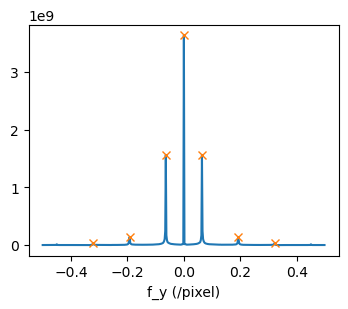

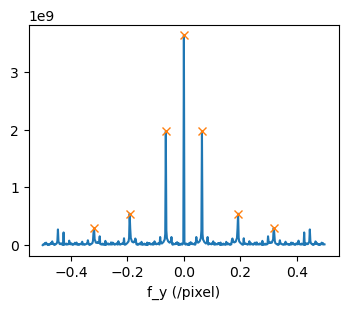

Initial guess: a, x0, sigma = [1.0012068019243556, 2.078682396712272e-18, 0.12173625303583903]
Fitted parameters: a, x0, sigma = [9.45818654e-01 2.07868240e-18 1.22025283e-01]


/home/srayan/miniconda3/envs/opt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


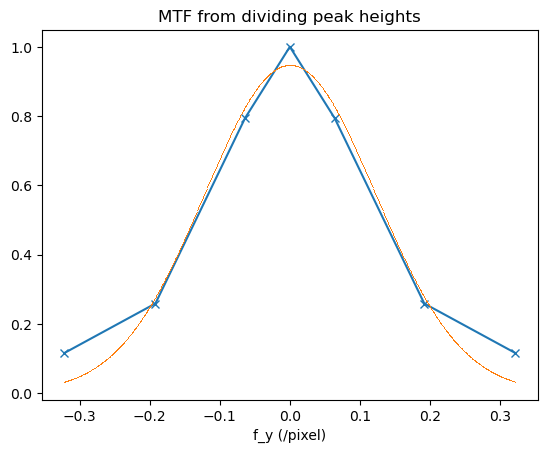

In [15]:
true_mtf_x, true_mtf_y, fitted_mtf_x, fitted_mtf_y = mtf_fit_gaussian(im, 11, E, thresh=0.275e9)

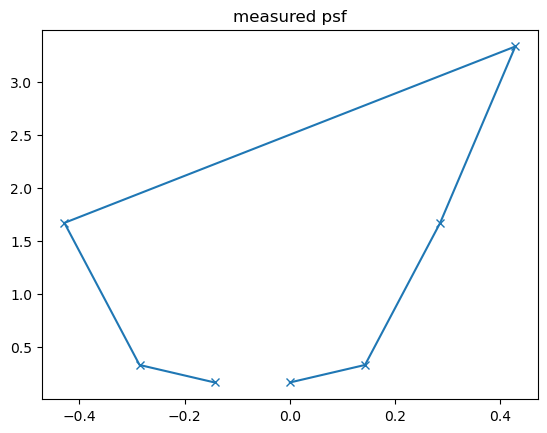

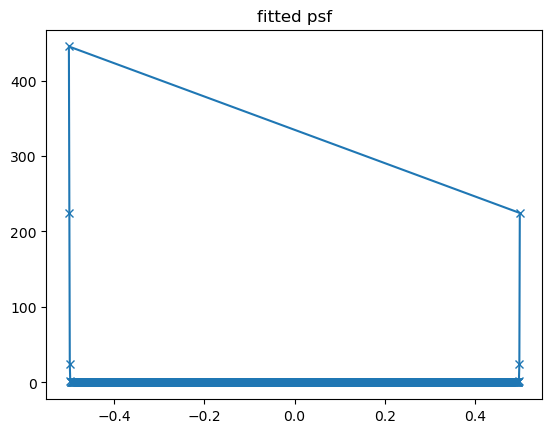

In [16]:
true_psf = np.fft.ifftshift(true_mtf_y)
true_psf = np.fft.fft(true_psf)
true_psf = np.fft.fftshift(true_psf)
true_pixels = np.fft.fftfreq(true_psf.shape[0])

# # deal with nans
# # stolen from https://stackoverflow.com/a/32800723
xi = np.arange(len(fitted_mtf_y))
mask = np.isfinite(fitted_mtf_y)
xfiltered = np.interp(xi, xi[mask], fitted_mtf_y[mask])

fitted_psf = np.fft.ifftshift(xfiltered)
fitted_psf = np.fft.fft(fitted_psf)
fitted_psf = np.fft.fftshift(fitted_psf)
fitted_pixels = np.fft.fftfreq(fitted_psf.shape[0])

plt.plot(true_pixels, np.abs(true_psf), '-x')
plt.title('measured psf')
plt.show()
plt.plot(fitted_pixels, np.abs(fitted_psf), '-x')
plt.title('fitted psf')
plt.show()

---

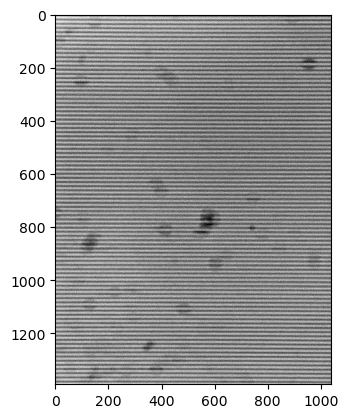

In [17]:
# trying diplib just for fun

img = dip.ImageReadTIFF(f22)
img.Show()

In [18]:
otf = dip.IncoherentOTF(img)
# returns none
# how does this work?!?!?!
# docs here: https://diplib.org/diplib-docs/microscopy.html#dip-IncoherentOTF-dip-Image-L-dip-dfloat--dip-dfloat--dip-dfloat--dip-String-CL